# How to manipulate & plot DNF `countme` data with `pandas`!

Hello! This is a Jupyter notebook that demonstrates how to use the `pandas` python library to mess around with the DNF `countme` data.



## Table of contents

1. [Setup](#setup)
2. [Load / parse CSV data](#load_csv)
3. [Indexing and slicing](#index_slice)
4. [Grouping data and counting hosts](#group_count_hosts)
5. [More fun with `unstack()` and `pivot_table()`](#unstack_pivot)
6. [Actually making charts & graphs](#plot)

## Setup <a name="setup">

I should probably have some instructions here about how to install `pandas` and load this notebook for interactive use... oh well, there's always cut-and-paste.
    
Anyway, here's your usual python imports and some constants that we'll use through the rest of the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# BASEARCHES is  list of all $basearch values known to DNF, generated with:
#     import dnf
#     BASEARCHES = set(dnf.rpm._BASEARCH_MAP.values())
# then grouped by current status and ordered by frequency.
BASEARCHES = [
    # F32 primary arches
    'x86_64', 'aarch64', 'armhfp',
    # F32 secondary arches
    'ppc64le', 's390x', 'mipsel', 'mips64el', 'riscv64',
    # Historical Fedora arches
    'i386', 'ia64', 'arm', 'ppc', 'ppc64', 's390', 'sparc'
    # Other arches DNF knows about, but (afaik) we've never built Fedora for
    'alpha', 'mips', 'mips64', 'riscv32', 'riscv128', 'sh3', 'sh4',
    # This could be a valid repo_arch (but not os_arch!)
    'noarch'
]

# SYS_AGES is an array/index of timedeltas that correspond to sys_age values.
# sys_age=1 -> [0w, 2w), sys_age=2 -> [2w, 5w), etc.
# (Defined in COUNTME_BUCKETS in libdnf/libdnf/repo/Repo.cpp)
SYS_AGES = pd.to_timedelta(['0w', '2w', '5w', '25w'])

In [3]:
# Column names!
# It's convenient to have the column names split up by their function, so:

# os_id_cols identify the OS itself
os_id_cols = ['os_name', 'os_version', 'os_variant']

# sys_id_cols are properties of the client system
sys_id_cols = ['os_arch', 'sys_age']

# repo_id_cols identify the requested repo, not the host itself
repo_id_cols = ['repo_tag', 'repo_arch']

# id_cols represents all the identifier/index columns.
id_cols = os_id_cols + sys_id_cols + repo_id_cols

# host_id_cols is the unique identifier for the host, or: "everything but the repo"
host_id_cols = [c for c in id_cols if c not in repo_id_cols]

## Load / parse CSV data <a name="load_csv">
   

In [4]:
# Read the CSV data and do a little data type massaging.

# Here's a couple pre-defined categorical types we'll use.
# Any arch or age value outside these values should be considered an error.
arch_cat_dtype = pd.CategoricalDtype(categories=BASEARCHES)
age_cat_dtype = pd.CategoricalDtype(categories=[1,2,3,4], ordered=True)

# Okay, actually read the CSV, parsing dates and setting data types as we go.
totals = pd.read_csv("../totals.csv",
    parse_dates=['week_start', 'week_end'],
    dtype={
        'os_name':    'category',
        'os_version': 'category',
        'os_variant': 'category',
        'repo_tag':   'category',
        'os_arch':    arch_cat_dtype,
        'repo_arch':  arch_cat_dtype,
        'sys_age':    age_cat_dtype,
        # NOTE: change to int64 when we get >= 4 billion users per week :P
        'hits':       np.int32, 
    }
)

# This is just here to show the contents of 'totals' in the Jupyter notebook.
totals

,week_start,week_end,hits,os_name,os_version,os_variant,os_arch,sys_age,repo_tag,repo_arch
0,2020-02-10,2020-02-16,2,Fedora,31,generic,x86_64,3,fedora-modular-31,x86_64
1,2020-02-10,2020-02-16,2,Fedora,31,generic,x86_64,3,updates-released-f31,x86_64
2,2020-02-10,2020-02-16,1,Fedora,31,workstation,x86_64,3,updates-released-modular-f31,x86_64
3,2020-02-10,2020-02-16,2,Fedora,31,workstation,x86_64,3,fedora-31,x86_64
4,2020-02-10,2020-02-16,2,Fedora,31,generic,x86_64,3,updates-released-modular-f31,x86_64
...,...,...,...,...,...,...,...,...,...,...
16403,2020-07-20,2020-07-26,1,Fedora,33,generic,x86_64,2,updates-released-f32,x86_64
16404,2020-07-20,2020-07-26,1,Fedora,32,cloud,x86_64,1,fedora-30,x86_64
16405,2020-07-20,2020-07-26,1,Fedora,32,cloud,x86_64,1,fedora-modular-30,x86_64
16406,2020-07-20,2020-07-26,1,Fedora,32,server,aarch64,1,updates-testing-f32,aarch64


In [5]:
# Here's what values we saw for os_name, os_version, and os_variant..
for col in os_id_cols:
    print(f'{col}: {totals[col].cat.categories}')

os_name: Index(['CentOS Linux', 'Centos', 'FSystem', 'Fan-Linux OS', 'Fedora',
       'Fedora Remix for WSL', 'Fedora-Android', 'Fedoraa', 'Generic',
       'JambulaOS', 'Magic', 'NST', 'OsoLinux', 'PetalOS',
       'Private Void Enterprise Linux', 'Red Hat Enterprise Linux',
       'Red Hat Enterprise Linux Server', 'RedHat', 'SONICast', 'SuperRed',
       'Top Hat', 'UXCloud', 'Ubuntu', 'VirtOS', 'XF', 'brynux'],
      dtype='object')
os_version: Index(['10000', '11', '18.04', '2.0.8.1', '20.06', '29', '30', '31', '32',
       '33', '50', '7', '7.7', '7.8', '8', '8.1', '8.2', 'rawhide'],
      dtype='object')
os_variant: Index(['cinnamon', 'cloud', 'container', 'coreos', 'generic', 'gnome', 'iot',
       'kde', 'matecompiz', 'rawhide', 'server', 'silverblue', 'snappy',
       'soas', 'workstation', 'xfce'],
      dtype='object')


## Indexing and slicing <a name="index_slice">

In [6]:
# Instead of having 'week_start'/'week_end' as individual columns, make a
# periodic index where each 'week' item covers the entire week's timespan.
# (W-SUN means "week ends on Sunday")
week_index = pd.PeriodIndex(data=totals['week_start'], name='week', freq='W-SUN')

# Add that index and drop `week_start` / `week_end`
week_totals = totals.set_index(week_index).drop(columns=['week_start', 'week_end'])

# Let's have a look!
week_totals

,hits,os_name,os_version,os_variant,os_arch,sys_age,repo_tag,repo_arch
week,,,,,,,,
2020-02-10/2020-02-16,2,Fedora,31,generic,x86_64,3,fedora-modular-31,x86_64
2020-02-10/2020-02-16,2,Fedora,31,generic,x86_64,3,updates-released-f31,x86_64
2020-02-10/2020-02-16,1,Fedora,31,workstation,x86_64,3,updates-released-modular-f31,x86_64
2020-02-10/2020-02-16,2,Fedora,31,workstation,x86_64,3,fedora-31,x86_64
2020-02-10/2020-02-16,2,Fedora,31,generic,x86_64,3,updates-released-modular-f31,x86_64
...,...,...,...,...,...,...,...,...
2020-07-20/2020-07-26,1,Fedora,33,generic,x86_64,2,updates-released-f32,x86_64
2020-07-20/2020-07-26,1,Fedora,32,cloud,x86_64,1,fedora-30,x86_64
2020-07-20/2020-07-26,1,Fedora,32,cloud,x86_64,1,fedora-modular-30,x86_64


In [7]:
# Having a PeriodicIndex is handy for a bunch of reasons.
# For example - you can use arbitrary dates/timestamps and pandas will figure out
# which week that belongs to. Like so:
week_totals.loc['July 4 2020']

,hits,os_name,os_version,os_variant,os_arch,sys_age,repo_tag,repo_arch
week,,,,,,,,
2020-06-29/2020-07-05,27033,Fedora,32,workstation,x86_64,1,fedora-modular-32,x86_64
2020-06-29/2020-07-05,19872,Fedora,32,workstation,x86_64,2,updates-released-f32,x86_64
2020-06-29/2020-07-05,28819,Fedora,32,workstation,x86_64,1,updates-released-modular-f32,x86_64
2020-06-29/2020-07-05,29099,Fedora,32,workstation,x86_64,1,updates-released-f32,x86_64
2020-06-29/2020-07-05,26896,Fedora,32,workstation,x86_64,1,fedora-32,x86_64
...,...,...,...,...,...,...,...,...
2020-06-29/2020-07-05,1,Fedora,33,container,x86_64,2,updates-testing-f33,x86_64
2020-06-29/2020-07-05,1,Generic,32,generic,x86_64,1,updates-released-modular-f31,x86_64
2020-06-29/2020-07-05,1,Fedora,31,workstation,x86_64,1,fedora-32,x86_64


In [8]:
# Or if you just want the most recent week's data:
last_week = week_totals.index.max()
week_totals.loc[last_week]

,hits,os_name,os_version,os_variant,os_arch,sys_age,repo_tag,repo_arch
week,,,,,,,,
2020-07-20/2020-07-26,73714,Fedora,32,workstation,x86_64,3,updates-released-f32,x86_64
2020-07-20/2020-07-26,5,Fedora,32,server,x86_64,1,updates-released-modular-f31,x86_64
2020-07-20/2020-07-26,1896,Fedora,32,server,x86_64,2,fedora-32,x86_64
2020-07-20/2020-07-26,69191,Fedora,32,workstation,x86_64,3,fedora-32,x86_64
2020-07-20/2020-07-26,1981,Fedora,32,server,x86_64,2,updates-released-modular-f32,x86_64
...,...,...,...,...,...,...,...,...
2020-07-20/2020-07-26,1,Fedora,33,generic,x86_64,2,updates-released-f32,x86_64
2020-07-20/2020-07-26,1,Fedora,32,cloud,x86_64,1,fedora-30,x86_64
2020-07-20/2020-07-26,1,Fedora,32,cloud,x86_64,1,fedora-modular-30,x86_64


In [9]:
# In practice, we want to index over time and all 'identifier' columns:
idx_totals = week_totals.set_index(id_cols, append=True)
idx_totals

hits
week                  os_name os_version os_variant  os_arch sys_age repo_tag                     repo_arch      
2020-02-10/2020-02-16 Fedora  31         generic     x86_64  3       fedora-modular-31            x86_64        2
                                                                     updates-released-f31         x86_64        2
                                         workstation x86_64  3       updates-released-modular-f31 x86_64        1
                                                                     fedora-31                    x86_64        2
                                         generic     x86_64  3       updates-released-modular-f31 x86_64        2
...                                                                                                           ...
2020-07-20/2020-07-26 Fedora  33         generic     x86_64  2       updates-released-f32         x86_64        1
                              32         cloud       x86_64  1       fedora-30                    x86_64        1
                                                                     fedora-modular-30            x86_64        1
                                         server      aarch64 1       updates-testing-f32          aarch64       1
                                         generic     x86_64  1       fedora-modular-30            x86_64        1

[16408 rows x 1 columns]

In [10]:
# We can now slice this data in all kinda of fun ways to give us only the bits we're interested in.
# Let's see Fedora 31 x86_64 systems for one particular week in July 2020.
# (There's a bunch of different ways to slice - see the pandas docs for more info)
All = slice(None)
idx_totals.loc[('2020-07-13', 'Fedora', '31', All, 'x86_64'), All]

hits
week                  os_name os_version os_variant  os_arch sys_age repo_tag                     repo_arch      
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  3       fedora-modular-31            x86_64        3
                                                                     updates-released-modular-f31 x86_64        3
                                                                     updates-released-f31         x86_64        3
                                                             1       updates-released-modular-f31 x86_64        2
                                                                     updates-released-f31         x86_64        1
                                                                     fedora-31                    x86_64        1
                                                             3       fedora-31                    x86_64        3
                                                             4       fedora-31                    x86_64        1
                                                             1       fedora-modular-31            x86_64        1
                                                             4       updates-released-modular-f31 x86_64        1
                                                                     fedora-modular-31            x86_64        1
                                                                     updates-released-f31         x86_64        1
                                         workstation x86_64  2       updates-released-modular-f32 x86_64        1
                                                                     fedora-modular-32            x86_64        1
                                                                     updates-released-f32         x86_64        1
                                                                     fedora-32                    x86_64        1
                                                             1       fedora-32                    x86_64        2
                                         generic     x86_64  2       fedora-modular-31            x86_64        1
                                                                     updates-released-f31         x86_64        1
                                                                     updates-released-modular-f31 x86_64        1
                                                                     fedora-31                    x86_64        1
                                                             1       fedora-modular-32            x86_64        1
                                         workstation x86_64  2       updates-released-f31         x86_64        1
                                                                     fedora-modular-31            x86_64        1
                                                                     fedora-31                    x86_64        1
                                         generic     x86_64  3       updates-testing-modular-f31  x86_64        1

In [11]:
# We can save the "slicer" itself and reuse it later:
lil_slice = ('2020-07-13', 'Fedora', '31', All, 'x86_64'), All
idx_totals.loc[lil_slice]

hits
week                  os_name os_version os_variant  os_arch sys_age repo_tag                     repo_arch      
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  3       fedora-modular-31            x86_64        3
                                                                     updates-released-modular-f31 x86_64        3
                                                                     updates-released-f31         x86_64        3
                                                             1       updates-released-modular-f31 x86_64        2
                                                                     updates-released-f31         x86_64        1
                                                                     fedora-31                    x86_64        1
                                                             3       fedora-31                    x86_64        3
                                                             4       fedora-31                    x86_64        1
                                                             1       fedora-modular-31            x86_64        1
                                                             4       updates-released-modular-f31 x86_64        1
                                                                     fedora-modular-31            x86_64        1
                                                                     updates-released-f31         x86_64        1
                                         workstation x86_64  2       updates-released-modular-f32 x86_64        1
                                                                     fedora-modular-32            x86_64        1
                                                                     updates-released-f32         x86_64        1
                                                                     fedora-32                    x86_64        1
                                                             1       fedora-32                    x86_64        2
                                         generic     x86_64  2       fedora-modular-31            x86_64        1
                                                                     updates-released-f31         x86_64        1
                                                                     updates-released-modular-f31 x86_64        1
                                                                     fedora-31                    x86_64        1
                                                             1       fedora-modular-32            x86_64        1
                                         workstation x86_64  2       updates-released-f31         x86_64        1
                                                                     fedora-modular-31            x86_64        1
                                                                     fedora-31                    x86_64        1
                                         generic     x86_64  3       updates-testing-modular-f31  x86_64        1

In [12]:
# Alternate method: using the cross-section function .xs() can be clearer.
idx_totals.xs(level=('week', 'os_name', 'os_version', 'os_arch'),
              key=('2020-07-13', 'Fedora', '31', 'x86_64'),
              drop_level=False)

hits
week                  os_name os_version os_variant  os_arch sys_age repo_tag                     repo_arch      
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  3       fedora-modular-31            x86_64        3
                                                                     updates-released-modular-f31 x86_64        3
                                                                     updates-released-f31         x86_64        3
                                                             1       updates-released-modular-f31 x86_64        2
                                                                     updates-released-f31         x86_64        1
                                                                     fedora-31                    x86_64        1
                                                             3       fedora-31                    x86_64        3
                                                             4       fedora-31                    x86_64        1
                                                             1       fedora-modular-31            x86_64        1
                                                             4       updates-released-modular-f31 x86_64        1
                                                                     fedora-modular-31            x86_64        1
                                                                     updates-released-f31         x86_64        1
                                         workstation x86_64  2       updates-released-modular-f32 x86_64        1
                                                                     fedora-modular-32            x86_64        1
                                                                     updates-released-f32         x86_64        1
                                                                     fedora-32                    x86_64        1
                                                             1       fedora-32                    x86_64        2
                                         generic     x86_64  2       fedora-modular-31            x86_64        1
                                                                     updates-released-f31         x86_64        1
                                                                     updates-released-modular-f31 x86_64        1
                                                                     fedora-31                    x86_64        1
                                                             1       fedora-modular-32            x86_64        1
                                         workstation x86_64  2       updates-released-f31         x86_64        1
                                                                     fedora-modular-31            x86_64        1
                                                                     fedora-31                    x86_64        1
                                         generic     x86_64  3       updates-testing-modular-f31  x86_64        1

## Grouping data and counting hosts <a name="group_count_hosts">

In [13]:
# Okay, enough introductions.
# Here's the important part: counting hosts vs. counting hits.
# Since each host can hit multiple repos, we can't just add up hits.
# Our best guess at the number of unique hosts we saw (for each host identifier)
# is the maximum number of hits we saw from that host_id across all repos.
# So: we group by all the host identifiers and generate two aggregate values:
#   'hits' is the total number of hits we saw with that host id (across all repos)
#   'hosts' is the max per-repo number of hits we saw with that host id,
#           which is our best-guess number of unique hosts with that host_id.
host_totals = (
    week_totals
    .groupby(['week']+host_id_cols, observed=True)
    #.agg(hits=('hits', 'sum'), hosts=('hits', 'max'))
    .agg(hosts=('hits', 'max'), hits=('hits', 'sum'))
)
# Looking at that same slice - now we have some numbers we can work with!
host_totals.loc[lil_slice]

hosts  \
week                  os_name os_version os_variant  os_arch sys_age          
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  1            2   
                                                             2            1   
                                                             3            3   
                                                             4            1   
                                         workstation x86_64  1            2   
                                                             2            1   

                                                                      hits  
week                  os_name os_version os_variant  os_arch sys_age        
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  1           6  
                                                             2           4  
                                                             3          13  
                                                             4           4  
                                         workstation x86_64  1           2  
                                                             2           7

In [14]:
# Here's a step-by-step explanation to show why we count hosts that way.
# Each host will send only one `countme` *per repo* per week, but they can hit multiple repos per week.
# To illustrate that, let's take that slice and change the axes around so we have one column for each
# repo_tag and repo_arch.
idx_totals.loc[lil_slice].unstack(repo_id_cols, fill_value=0)

hits  \
repo_tag                                                             fedora-modular-31   
repo_arch                                                                       x86_64   
week                  os_name os_version os_variant  os_arch sys_age                     
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  1                       1   
                                                             2                       1   
                                                             3                       3   
                                                             4                       1   
                                         workstation x86_64  1                       0   
                                                             2                       1   

                                                                                                   \
repo_tag                                                             updates-released-modular-f31   
repo_arch                                                                                  x86_64   
week                  os_name os_version os_variant  os_arch sys_age                                
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  1                                  2   
                                                             2                                  1   
                                                             3                                  3   
                                                             4                                  1   
                                         workstation x86_64  1                                  0   
                                                             2                                  0   

                                                                                           \
repo_tag                                                             updates-released-f31   
repo_arch                                                                          x86_64   
week                  os_name os_version os_variant  os_arch sys_age                        
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  1                          1   
                                                             2                          1   
                                                             3                          3   
                                                             4                          1   
                                         workstation x86_64  1                          0   
                                                             2                          1   

                                                                                \
repo_tag                                                             fedora-31   
repo_arch                                                               x86_64   
week                  os_name os_version os_variant  os_arch sys_age             
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  1               1   
                                                             2               1   
                                                             3               3   
                                                             4               1   
                                         workstation x86_64  1               0   
                                                             2               1   

                                                                                                   \
repo_tag                                                             updates-released-modular-f32   
repo_arch                                                                                  x86_64   
week                  os_name os_version os_variant  os_arch sys_age                                
2020-07-13/202

In [15]:
# Since each unique DNF client system can hit any combination of repos per week, our best guess at how many
# systems there are is the max() value of each row.
# Conveniently, the pivot_table() function is designed just for this kind of thing!
(
    idx_totals.loc[lil_slice]
    .pivot_table(index=['week']+host_id_cols, aggfunc='max')
    .rename(columns={'hits':'hosts'})
)

hosts
week                  os_name os_version os_variant  os_arch sys_age       
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  1            2
                                                             2            1
                                                             3            3
                                                             4            1
                                         workstation x86_64  1            2
                                                             2            1

In [16]:
# So, again, to make a dataframe where our values are approximate host counts,
# we index by week + host identifier columns and take the max value.
# We could have used pivot_table to generate the same host_totals frame as above.
assert(
    week_totals
    .pivot_table(values='hits', index=['week']+host_id_cols, observed=True, aggfunc=('sum', 'max'))
    .rename(columns={'sum':'hits', 'max':'hosts'})
    .equals(host_totals)
)

## More fun with `unstack()` and `pivot_table()` <a name="unstack_pivot">

In [17]:
# Here's a chart showing last week's unique hosts,
# by arch and system age:
(
    host_totals
    .loc[last_week]
    .unstack('os_arch', fill_value=0)
    .unstack('sys_age', fill_value=0)
)

hosts                   \
os_arch                                              x86_64                    
sys_age                                                   1      2      3  4   
os_name                       os_version os_variant                            
Fedora                        31         generic          1      1      5  1   
                                         workstation      2      1      1  0   
                                         server           1      0      0  0   
                              32         generic       8413   4272  18800  0   
                                         workstation  27579  17511  73714  1   
                                         server        3305   1997   6708  0   
                                         container     8315    382    419  0   
                                         cloud         7639   3300   2114  0   
                                         kde           2976   1501   4521  1   
                                         matecompiz     691    499   1832  0   
                                         xfce             7      3     36  0   
                                         cinnamon         5      7     33  0   
                                         silverblue      10      1      3  0   
                                         snappy           0      0      1  0   
                                         coreos           4      0      2  0   
                              33         generic        216     36   1032  0   
                                         workstation    217     79    185  0   
                                         server          32     12     65  0   
                                         container     1077      9     57  0   
                                         cloud          345      4     12  0   
                                         kde             40      9     20  0   
                                         matecompiz       5      3     11  0   
                                         xfce             3      1      2  0   
                                         cinnamon         2      4      3  0   
                                         rawhide          0      0      1  0   
                              29         workstation      0      0      1  0   
                              8          kde              0      0      1  0   
                              rawhide    workstation      0      1      0  0   
Generic                       32         generic         40     45    203  0   
NST                           32         generic         22      6     18  0   
Red Hat Enterprise Linux      8.2        generic         92      0      0  0   
Private Void Enterprise Linux 32         workstation      0      0      1  0   
                                         server           0      0      2  0   
CentOS Linux                  8          generic          6      0      0  0   
                              7          generic          0      0      1  0   
Fedora Remix for WSL          31         generic          2      3      3  0   
                              32         generic          0      0      1  0   
OsoLinux                      32         kde              0      0      3  0   
UXCloud                       2.0.8.1    generic          3      2      0  0   
JambulaOS                     11         generic          1      0      0  0   
Top Hat                       32         generic          3      0      0  0   

                                                                         \
os_arch                                              ppc64le              
sys_age                                                    1   2   3  4   
os_name                       os_version os_variant                       
Fedora                        31         generic           0   0   0  0   
                                         workstation       0   0   0  0   
   

In [18]:
# Another way of showing the same data.
# Note that pivot_table removes empty columns with observed=True.
(
    host_totals
    .loc[last_week]
    .pivot_table(
        values='hosts',
        index=os_id_cols,
        columns=sys_id_cols,
        fill_value=0,
        observed=True
    )
)

os_arch                                              x86_64                   \
sys_age                                                   1      2      3  4   
os_name                       os_version os_variant                            
Fedora                        31         generic          1      1      5  1   
                                         workstation      2      1      1  0   
                                         server           1      0      0  0   
                              32         generic       8413   4272  18800  0   
                                         workstation  27579  17511  73714  1   
                                         container     8315    382    419  0   
                                         cloud         7639   3300   2114  0   
                                         server        3305   1997   6708  0   
                                         kde           2976   1501   4521  1   
                                         matecompiz     691    499   1832  0   
                                         xfce             7      3     36  0   
                                         cinnamon         5      7     33  0   
                                         silverblue      10      1      3  0   
                                         snappy           0      0      1  0   
                                         coreos           4      0      2  0   
                              33         generic        216     36   1032  0   
                                         workstation    217     79    185  0   
                                         container     1077      9     57  0   
                                         cloud          345      4     12  0   
                                         server          32     12     65  0   
                                         kde             40      9     20  0   
                                         matecompiz       5      3     11  0   
                                         xfce             3      1      2  0   
                                         cinnamon         2      4      3  0   
                                         rawhide          0      0      1  0   
                              29         workstation      0      0      1  0   
                              8          kde              0      0      1  0   
                              rawhide    workstation      0      1      0  0   
Generic                       32         generic         40     45    203  0   
NST                           32         generic         22      6     18  0   
Red Hat Enterprise Linux      8.2        generic         92      0      0  0   
Private Void Enterprise Linux 32         workstation      0      0      1  0   
                                         server           0      0      2  0   
CentOS Linux                  7          generic          0      0      1  0   
                              8          generic          6      0      0  0   
Fedora Remix for WSL          31         generic          2      3      3  0   
                              32         generic          0      0      1  0   
OsoLinux                      32         kde              0      0      3  0   
UXCloud                       2.0.8.1    generic          3      2      0  0   
JambulaOS                     11         generic          1      0      0  0   
Top Hat                       32         generic          3      0      0  0   

os_arch                                              aarch64          armhfp  \
sys_age                                                    1   2    3      1   
os_name                       os_version os_variant                            
Fedora                        31         generic           0   0    0      0   
                                         workstation       0   0    0      0   
                                         server            0   0    0      0   

## Actually making charts & graphs <a name="plot">

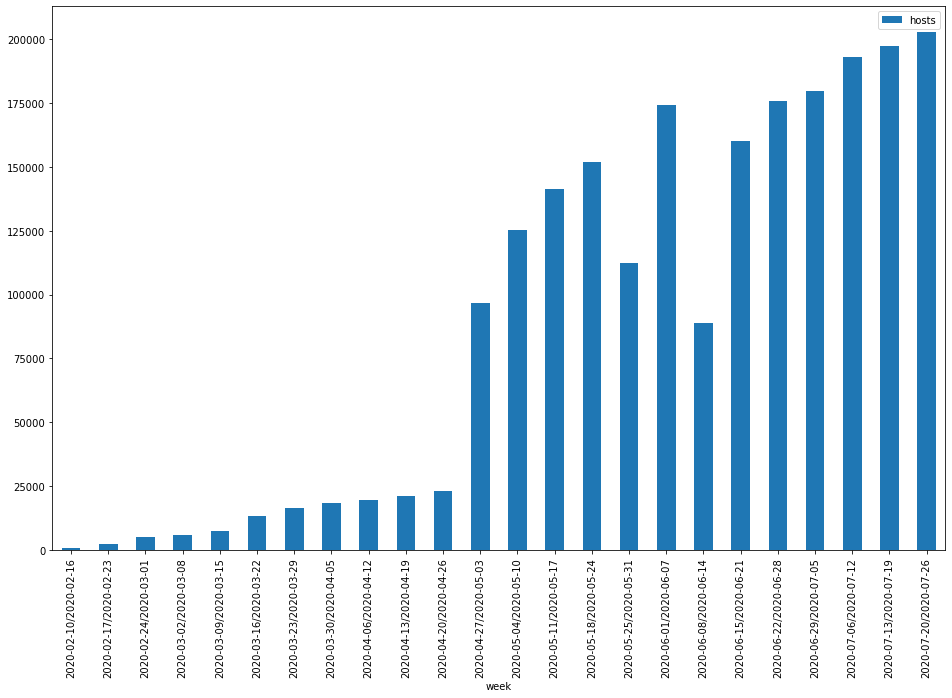

In [19]:
# Okay, let's make some graphs!
# pivot_table makes it pretty straightforward to get the data you want to plot:
# `index` gives the x-axis, `values` gives the values, and `aggfunc` names the
# function to use to collapse all the other index items.
# It's simpler than it sounds.
# Let's say you wanted a bar plot of the total number of hosts by week:
(
    host_totals
    .pivot_table(index='week', values='hosts', aggfunc='sum')
    .plot.bar(stacked=True, figsize=(16,10))
)

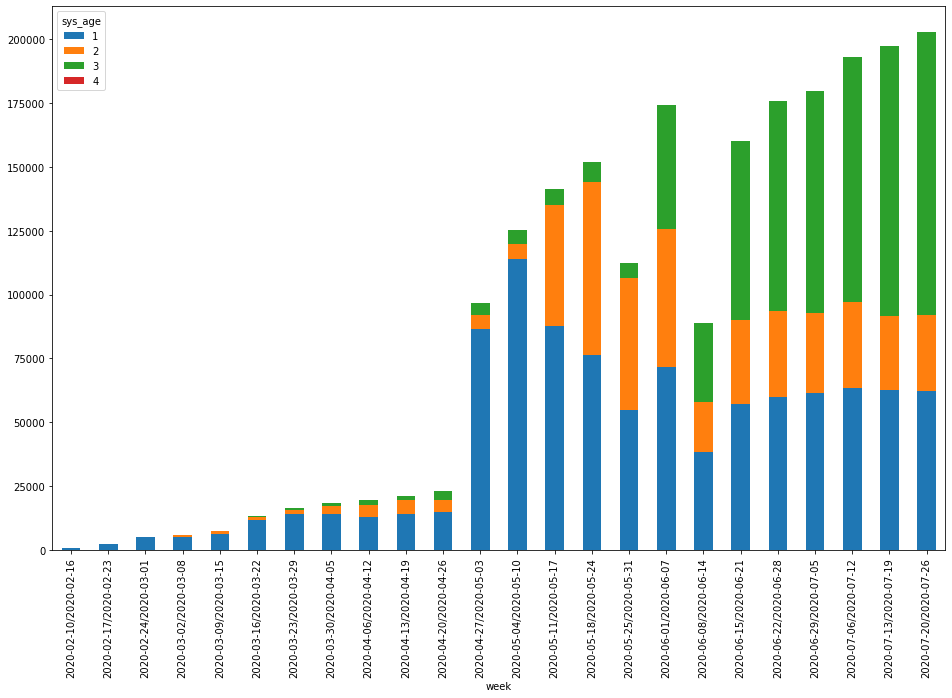

In [20]:
# If you give `columns`, you'll get a stacked bar plot.
# So if you wanted that plot with each bar split by sys_age:
(
    host_totals
    .pivot_table(index='week', values='hosts', aggfunc='sum', columns='sys_age')
    .plot.bar(stacked=True, figsize=(16,10))
)

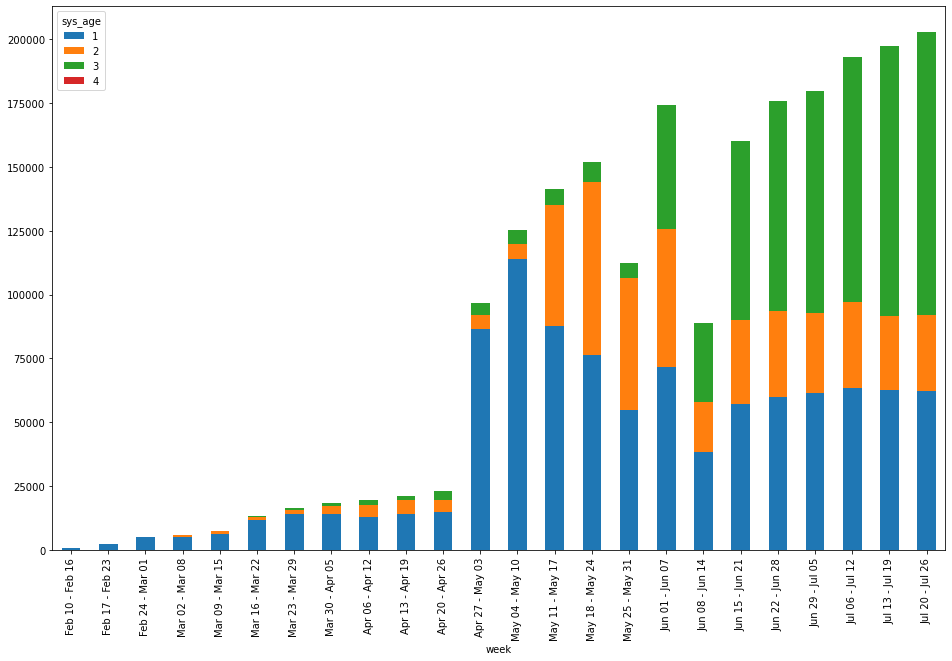

In [21]:
# Formatting the weekly labels is kinda tricky, because pandas drops the actual dates from the
# axis when it plots a PeriodIndex in a bar graph, so matplotlib tick locators/formatters
# won't work as expected. You can pretty easily change the labels, though.

pv = host_totals.pivot_table(index='week', values='hosts', aggfunc='sum', columns='sys_age')
ax = pv.plot.bar(stacked=True, figsize=(16,10))
                 
# New labels - just a list of strings, one per item in the index.
# Period objects have .start_time and .end_time attributes, which are datetimes
# and support the fancy strftime formatting. So this gives us date ranges like:
#     Mar 23 - Mar 29
#     Mar 30 - Apr 05
# etc.
weeklabels = [f"{p.start_time:%b %d} - {p.end_time:%b %d}" for p in pv.index]
ax.xaxis.set_ticklabels(weeklabels)
plt.show()